In [1]:
import sys
sys.path.append('/cellar/users/zkoch/methylation_and_mutation/source_files')
%load_ext autoreload
%aimport compute_comethylation, somatic_mut_clock
%autoreload 1
import get_data, analysis, utils, plotting, compute_comethylation, methyl_mut_burden, somatic_mut_clock

In [2]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
import pickle
import dask.dataframe as dd
from scipy.stats import spearmanr
from rich.progress import track
import statsmodels.formula.api as smf
import matplotlib.ticker as ticker
from scipy.stats import spearmanr
from scipy import stats
import dask
import sklearn
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV

%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-deep")

# Get data

In [3]:
out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_010423"
dependency_f_dir = "./dependency_files"
data_dir = "./data"
corr_dir = '/cellar/users/zkoch/methylation_and_mutation/dependency_files/chr_dset_corrs'
methylation_dir = '/cellar/users/zkoch/methylation_and_mutation/data/dropped3SD_qnormed_methylation'

In [4]:
illumina_cpg_locs_df, all_mut_df, all_methyl_df, all_methyl_df_t, all_meta_df, dataset_names_list = get_data.main(
    illum_cpg_locs_fn = os.path.join(dependency_f_dir, "illumina_cpg_450k_locations.csv"),
    out_dir = out_dir,
    methyl_dir = methylation_dir,
    mut_fn = os.path.join(data_dir, "PANCAN_mut.tsv.gz"),
    meta_fn = os.path.join(data_dir, "PANCAN_meta.tsv"))

Got mutations and metadata, reading methylation
Converting Dask df to pandas df, takes ~10min
Got methylation, transposing
Done


In [5]:
# read in other already computed files
# from running analysis.main() 
mut_in_measured_cpg_w_methyl_age_df = pd.read_parquet(os.path.join(dependency_f_dir, "mut_in_measured_cpg_w_methyl_age_df_5year.parquet"))
# add ages to all_methyl_df_t
all_mut_w_age_df, all_methyl_age_df_t = utils.add_ages_to_mut_and_methyl(all_mut_df, all_meta_df, all_methyl_df_t)


In [9]:
mut_clock.all_methyl_age_df_t

,age_at_index,cg00000165,cg00000292,cg00000363,cg00000658,cg00000721,cg00000734,cg00000769,cg00000905,cg00000924,...,dataset_SARC,dataset_SKCM,dataset_STAD,dataset_TGCT,dataset_THCA,dataset_THYM,dataset_UCEC,dataset_UCS,dataset_UVM,dataset
sample,,,,,,,,,,,,,,,,,,,,,
TCGA-OR-A5J1,58,0.859881,0.369579,0.159105,0.748348,0.924255,0.053660,0.032358,0.059654,0.437789,...,0,0,0,0,0,0,0,0,0,ACC
TCGA-OR-A5J3,23,0.210855,0.793523,0.658223,0.725128,0.931585,0.065195,0.026210,0.085379,0.387514,...,0,0,0,0,0,0,0,0,0,ACC
TCGA-OR-A5J4,23,0.819534,0.808722,0.673354,0.818173,0.930655,0.063775,0.028458,0.067232,0.203079,...,0,0,0,0,0,0,0,0,0,ACC
TCGA-OR-A5J5,30,0.861848,0.576721,0.127737,0.613099,0.909830,0.090215,0.038376,0.076752,0.195052,...,0,0,0,0,0,0,0,0,0,ACC
TCGA-OR-A5J6,29,0.239104,0.811813,0.249603,0.817582,0.943030,0.038255,0.027748,0.100806,0.346903,...,0,0,0,0,0,0,0,0,0,ACC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-YZ-A980,75,0.147520,0.664505,0.122693,0.741549,0.928594,0.054149,0.032668,0.059559,0.353919,...,0,0,0,0,0,0,0,0,1,UVM
TCGA-YZ-A982,79,0.324086,0.840877,0.415495,0.697945,0.913303,0.114920,0.061779,0.055176,0.426523,...,0,0,0,0,0,0,0,0,1,UVM
TCGA-YZ-A983,51,0.610780,0.842104,0.654260,0.669314,0.939721,0.075061,0.032258,0.059577,0.389017,...,0,0,0,0,0,0,0,0,1,UVM


In [17]:
mut_clock.all_methyl_age_df_t.columns[-37:]

Index(['ch.X.116673198R', 'gender_FEMALE', 'gender_MALE', 'dataset_ACC',
       'dataset_BLCA', 'dataset_BRCA', 'dataset_CESC', 'dataset_CHOL',
       'dataset_COAD', 'dataset_DLBC', 'dataset_ESCA', 'dataset_GBM',
       'dataset_HNSC', 'dataset_KICH', 'dataset_KIRC', 'dataset_KIRP',
       'dataset_LAML', 'dataset_LGG', 'dataset_LIHC', 'dataset_LUAD',
       'dataset_LUSC', 'dataset_MESO', 'dataset_OV', 'dataset_PAAD',
       'dataset_PCPG', 'dataset_PRAD', 'dataset_READ', 'dataset_SARC',
       'dataset_SKCM', 'dataset_STAD', 'dataset_TGCT', 'dataset_THCA',
       'dataset_THYM', 'dataset_UCEC', 'dataset_UCS', 'dataset_UVM',
       'dataset'],
      dtype='object')

In [19]:
mut_clock.all_methyl_age_df_t.loc[mut_clock.all_methyl_age_df_t['dataset'] == 'BRCA', 'gender_FEMALE'].value_counts()

1    774
0      9
Name: gender_FEMALE, dtype: int64

# Somatic mutation clock

In [ ]:
# For each CpG
# STEP 1: Filter to mutated sites on same chr
# STEP 2: predictor_sites:
#   most correlated
#   the site itself
#   any site from databases that affect the CpG
#   all sites within 2kb window
#   all sites with significant association 
# STEP 3: train linear model on the mutation status of predictor_sites
#   elasticNet bc greedily including many features 
# TODO: maybe try other models

In [ ]:
# Evaluate how well smeQTLs predict methylation status
# STEP 1: 5-fold CV with elasticNet (nested 5-fold) on each CpG
# STEP 2: record the cpg being predicted, r2's, MAEs, and selected feature names
# STEP 3: save this as a df 

In [ ]:
# TODO:
# Speed the predictor training way up
    # done-ish

# Second stage model: takes in predicted methylation and builds a standard epi clock
# STEP 1: For each sample, get the predicted methylation status for each CpG
# STEP 2: Feature selection (mutual information)
# STEP 3: ElasticNet
# OPTIONAL: 
    # add in a couple other features: mutation burden, C>T mutation burden
    # have a separate model for each tissue type

In [75]:
mut_clock = somatic_mut_clock.mutationClock(
    all_mut_w_age_df, 
    illumina_cpg_locs_df, 
    all_methyl_age_df_t,
    output_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_010423"
    )

In [7]:
# read in train and test samples
train_samples_fn = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_010423/train_samples.txt"
with open(train_samples_fn, "r") as f:
    training_samples = f.read().splitlines()
# read in train and test samples
test_samples_fn = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_010423/test_samples.txt"
with open(test_samples_fn, "r") as f:
    testing_samples = f.read().splitlines()

In [121]:
mut_clock.all_methyl_age_df_t.columns[1:11]

Index(['cg00000165', 'cg00000292', 'cg00000363', 'cg00000658', 'cg00000721',
       'cg00000734', 'cg00000769', 'cg00000905', 'cg00000924', 'cg00000948'],
      dtype='object')

In [125]:
result_df = mut_clock.train_all_predictors(
        train_samples = training_samples, num_correl_sites = 1000,
        max_meqtl_sites = 1000, nearby_window_size = 5000, aggregate = True,
        evaluate = True, cpg_ids = mut_clock.all_methyl_age_df_t.columns[1:31]
        )

0
10
20


#### New evaluate

In [16]:
res = mut_clock.evaluate_predictor(
    cpg_id = "cg00000363",
    train_samples = training_samples,
    num_correl_sites = 1000,
    max_meqtl_sites = 1000,
    nearby_window_size = 5000)

In [17]:
res

,cpg_id,mae,r2,feature_names,base_mae,base_r2,base_feature_names
0,cg00000363,"[0.10033689452142917, 0.10318097680530293, 0.1...","[0.49491339213037355, 0.4959612708751586, 0.49...","[[corr, matrixqtl, gender_FEMALE, gender_MALE,...","[0.10161347172547844, 0.10371389953860008, 0.1...","[0.4811490307712374, 0.4841816752407323, 0.483...","[[gender_FEMALE, gender_MALE, dataset_ACC, dat..."


#### Performance

In [ ]:
cpg_ids = mut_clock.all_methyl_age_df_t.columns[1000:1002]
train_samples_fn = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_010423/train_samples.txt"
with open(train_samples_fn, "r") as f:
    training_samples = f.read().splitlines()
clock_perf_df = mut_clock.train_all_predictors(num_correl_sites = 1000, max_meqtl_sites = 1000,
        nearby_window_size = 5000, cpg_ids = cpg_ids, train_samples = training_samples, evaluate = True
        )
clock_perf_df.to_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_122622/eval_results/501_1501_cpg_predictions_df.parquet")

In [28]:
clock_perf_df.to_csv('/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_010423/eval_results/611_711_preds.csv')

In [5]:
clock_perf_df3 = pd.read_csv("/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_010423/eval_results/501_511_preds.csv")
clock_perf_df2 = pd.read_csv("/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_010423/eval_results/511_561_preds.csv")
clock_perf_df1 = pd.read_csv('/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_010423/eval_results/611_711_preds.csv')

clock_perf_df = pd.concat([clock_perf_df1, clock_perf_df2, clock_perf_df3], axis=0)

In [30]:
def make_list(s):
    if type(s) == list:
        return [float(x) for x in s]
    return [float(x) for x in s.strip('][').split(', ')]

In [8]:
clock_perf_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_122622/all_cpg_predictions_df.parquet")
clock_perf_df2 = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_122622/501_1501_cpg_predictions_df.parquet")
clock_perf_df = pd.concat([clock_perf_df, clock_perf_df2], axis=0)

In [7]:
clock_perf_df_concat = clock_perf_df.copy(deep=True)

In [32]:
clock_perf_df_concat.loc['cg00042657', 'mae']


[0.011834285957344252, 0.012843321178797244, 0.01187158300378649]

In [128]:
clock_perf_df = result_df
#clock_perf_df.set_index("cpg_id", inplace=True)
clock_perf_df['mean_mae'] = clock_perf_df['mae'].apply(lambda x: np.mean(x))
clock_perf_df['mean_r2'] = clock_perf_df['r2'].apply(lambda x: np.mean(x))
clock_perf_df['base_mean_mae'] = clock_perf_df['base_mae'].apply(lambda x: np.mean(x))
clock_perf_df['base_mean_r2'] = clock_perf_df['base_r2'].apply(lambda x: np.mean(x))
clock_perf_df['num_features'] = clock_perf_df['feature_names'].apply(lambda x: len(x[0]))
clock_perf_df['base_num_features'] = clock_perf_df['base_feature_names'].apply(lambda x: len(x[0]))

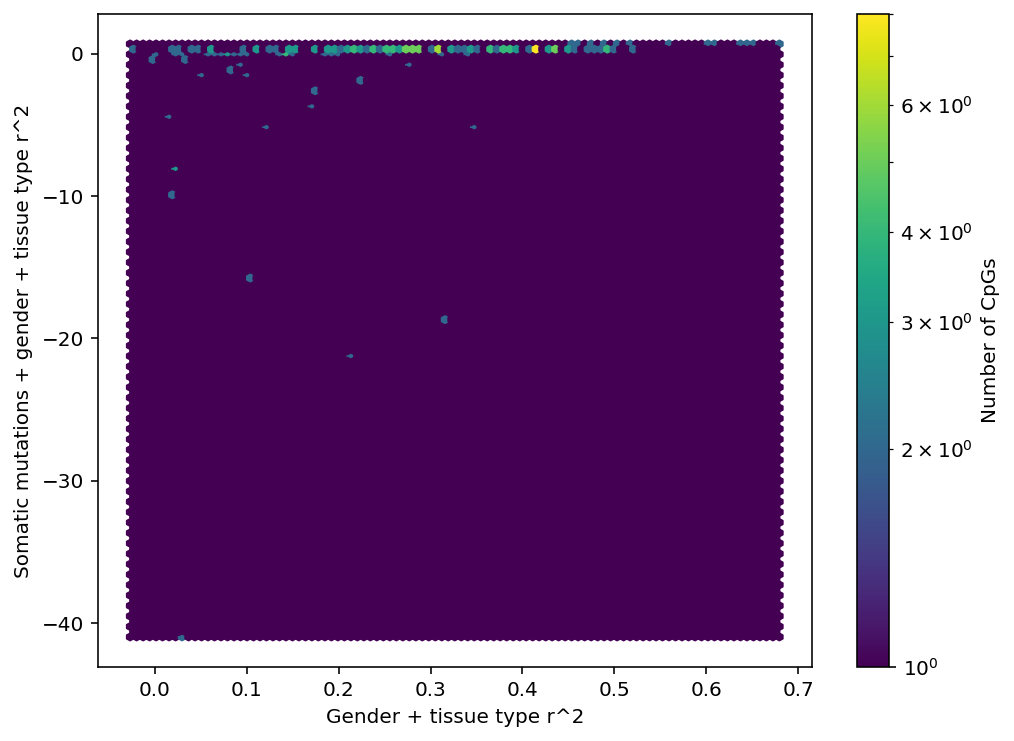

In [35]:
plt.rcParams["figure.figsize"] = (8,6)

plt.hexbin(clock_perf_df['base_mean_r2'], clock_perf_df['mean_r2'], bins='log')
plt.ylabel("Somatic mutations + gender + tissue type r^2")
plt.xlabel("Gender + tissue type r^2")
plt.colorbar( label = "Number of CpGs")
# set x and y range to 0,1


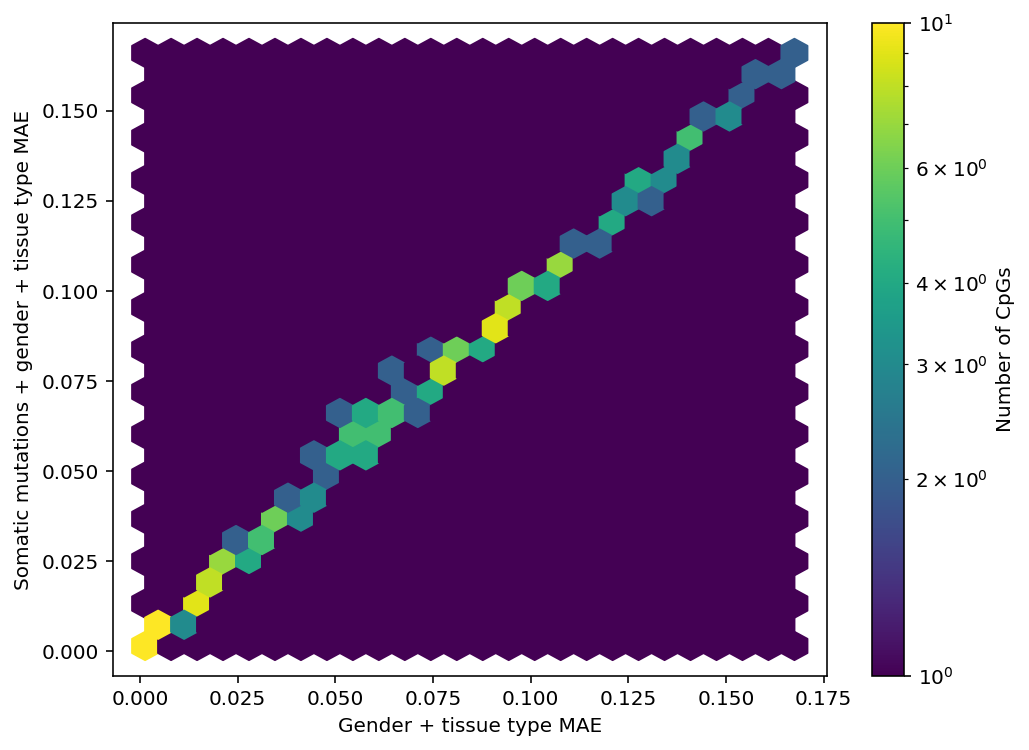

In [36]:
plt.rcParams["figure.figsize"] = (8,6)

plt.hexbin(clock_perf_df['base_mean_mae'], clock_perf_df['mean_mae'], gridsize=25, bins='log')
plt.ylabel("Somatic mutations + gender + tissue type MAE")
plt.xlabel("Gender + tissue type MAE")
plt.colorbar( label = "Number of CpGs")

array([[<AxesSubplot:title={'center':'mean_mae'}>,
        <AxesSubplot:title={'center':'base_mean_mae'}>],
       [<AxesSubplot:title={'center':'mean_r2'}>,
        <AxesSubplot:title={'center':'base_mean_r2'}>],
       [<AxesSubplot:title={'center':'num_features'}>,
        <AxesSubplot:title={'center':'base_num_features'}>]], dtype=object)

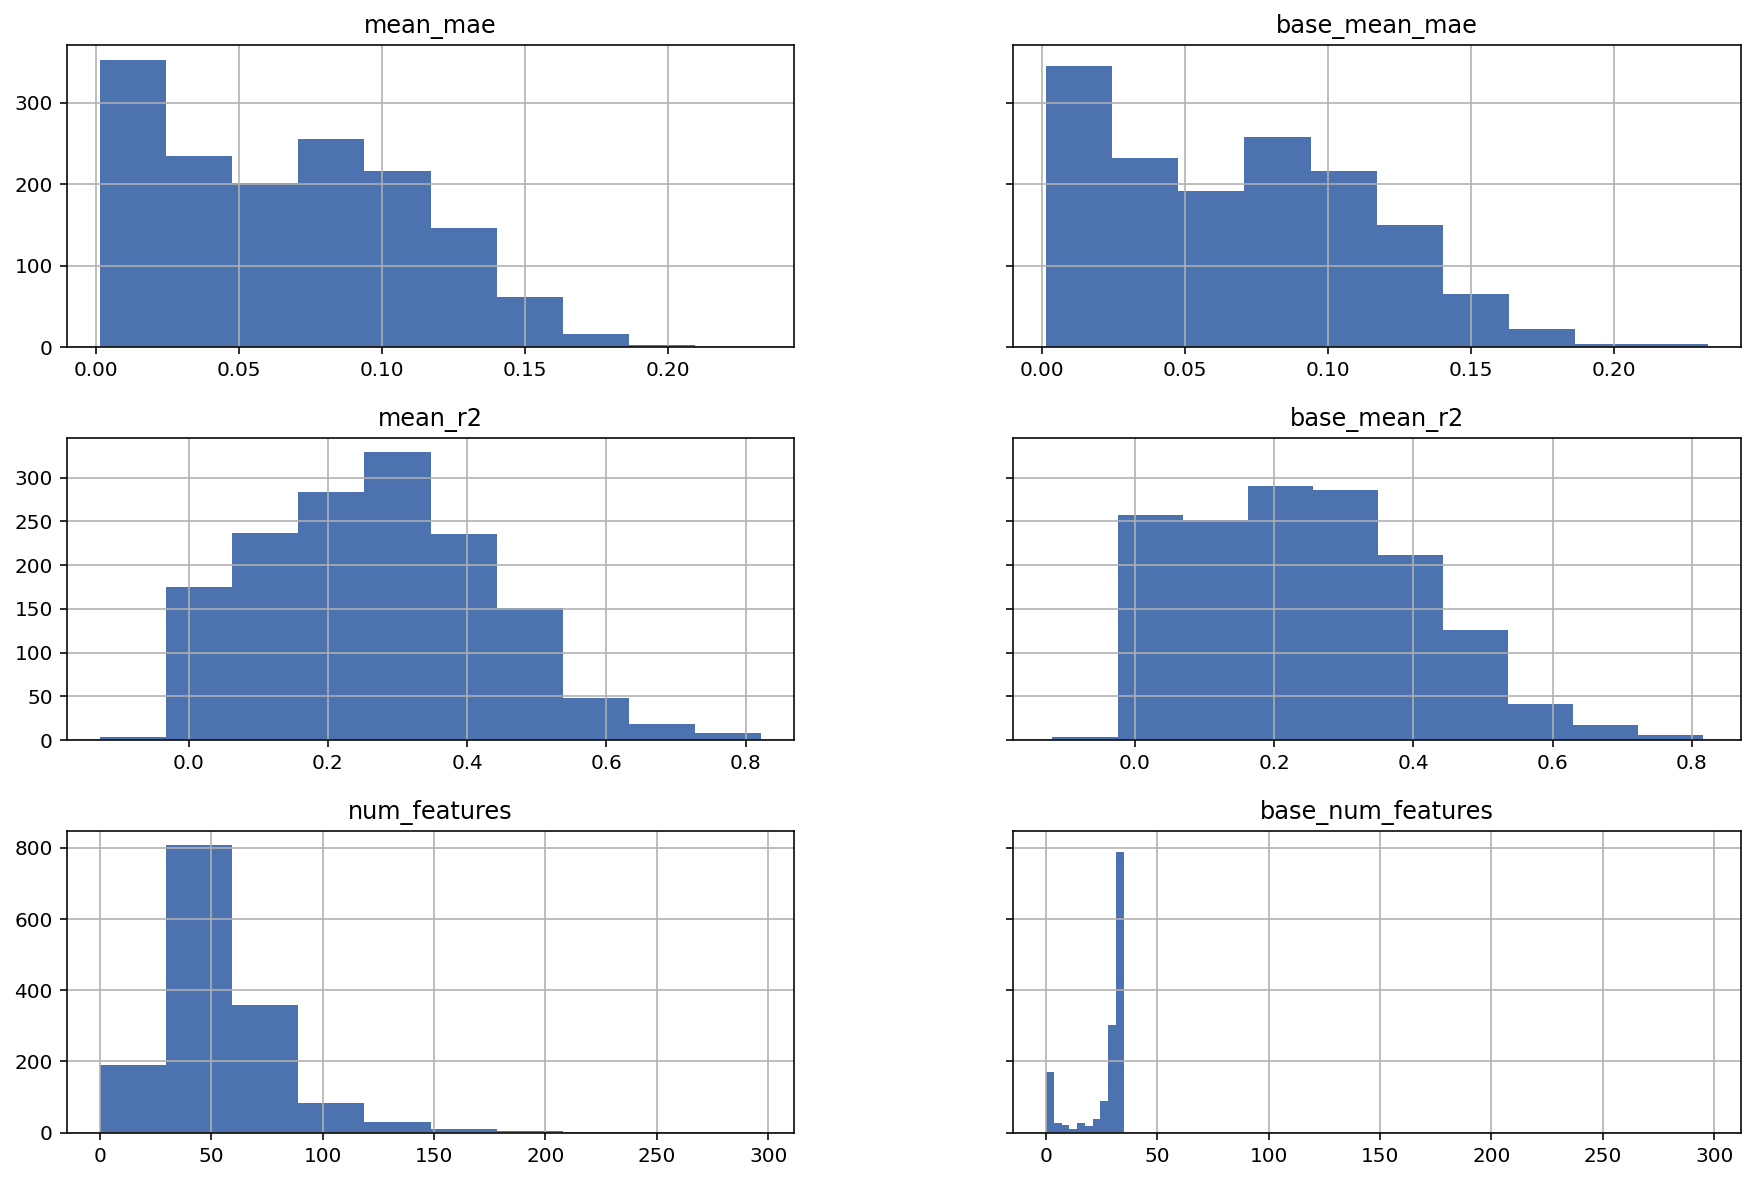

In [18]:
fig, axes = plt.subplots(3,2,figsize=(15, 10), sharex='row', sharey='row')
clock_perf_df[['mean_mae', 'base_mean_mae','mean_r2', 'base_mean_r2', 'num_features',   'base_num_features']].hist(ax = axes)

In [217]:
pred_methyl_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_010423/testing_predicted_methyl_top10000mi.parquet")

In [218]:
test_methyl_df = mut_clock.all_methyl_age_df_t.loc[testing_samples, pred_methyl_df.columns]

In [221]:
# calculate MAE between each column of pred_methyl_df and test_methyl_df
mae = np.abs(pred_methyl_df - test_methyl_df).mean(axis=0)

In [223]:
# calculate r^2 between each pair of columns of pred_methyl_df and test_methyl_df
r2 = np.array([np.corrcoef(pred_methyl_df[col], test_methyl_df[col])[0,1]**2 for col in pred_methyl_df.columns])

Text(0, 0.5, 'r^2')

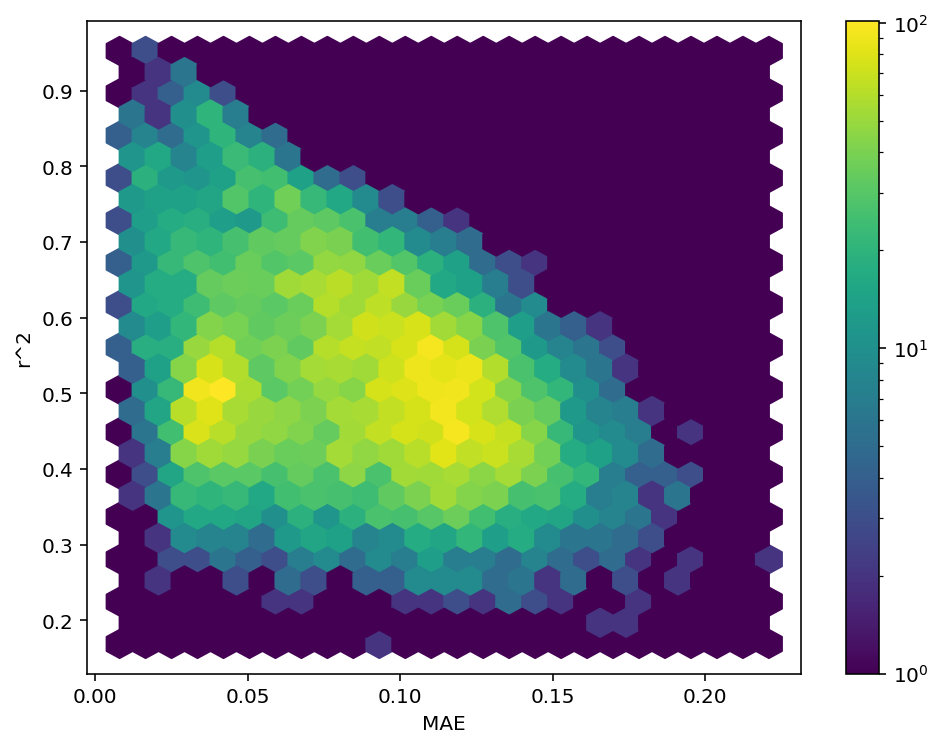

In [230]:
plt.hexbin(mae, r2, bins='log', gridsize=25)
plt.colorbar()
plt.xlabel("MAE")
plt.ylabel("r^2")

#### Define train and test

In [ ]:
# how to define the 80% training and 20% testing set?
    # randomly choose 20% of samples as testing, balancing dataset and age
    # use the rest for training
    # propogate this through having a file called train_samples.tsv and test_samples.tsv

In [134]:
from sklearn.model_selection import train_test_split

In [141]:
# balance dataset between training and testing
X_train, X_test = train_test_split(all_methyl_age_df_t, random_state=0, test_size=0.2, train_size=0.8, stratify=all_methyl_age_df_t['dataset'])

<AxesSubplot:>

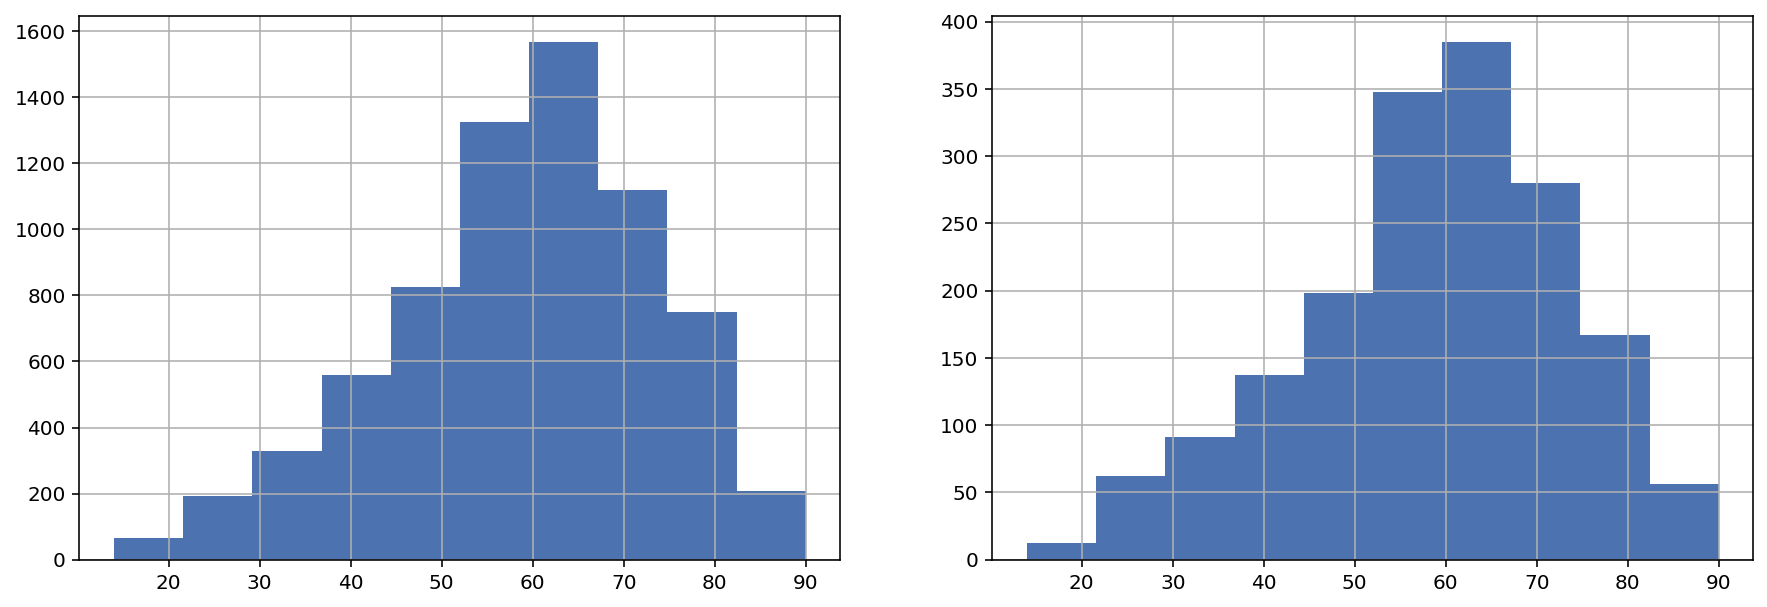

In [150]:
# this also results in a fairly balanced age distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
X_train['age_at_index'].hist(ax=axes[0])
X_test['age_at_index'].hist(ax = axes[1])


In [25]:
# read in train and test samples
train_samples_fn = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_010423/train_samples.txt"
with open(train_samples_fn, "r") as f:
    training_samples = f.read().splitlines()
# read in train and test samples
test_samples_fn = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_010423/test_samples.txt"
with open(test_samples_fn, "r") as f:
    testing_samples = f.read().splitlines()

#### Train predictors

In [13]:
mut_clock = somatic_mut_clock.mutationClock(
    all_mut_w_age_df, 
    illumina_cpg_locs_df, 
    all_methyl_age_df_t,
    output_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_010423"
    )

In [155]:
mut_clock.train_all_predictors(num_correl_sites = 1000, max_meqtl_sites = 1000, nearby_window_size = 5000, cpg_ids = ["cg18612167"], samples = all_methyl_age_df_t.index[:1000])

0


In [15]:
predictor_sites = mut_clock.get_predictor_sites(
    cpg_id = "cg18612167", train_samples = all_methyl_age_df_t.index[:1000], num_correl_sites = 1000,
    max_meqtl_sites = 1000, nearby_window_size = 5000
    )

In [159]:
df = mut_clock.evaluate_predictor(cpg_id="cg18612167", samples = all_methyl_age_df_t.index[:1000], predictor_sites=predictor_sites)

In [20]:
mut_clock.illumina_cpg_locs_df

,#id,chr,start,Strand
11648,cg00000165,1,91194674,R
11649,cg00000363,1,230560793,F
11650,cg00000957,1,5937253,F
11651,cg00001349,1,166958439,R
11653,cg00001446,1,43831041,R
...,...,...,...,...
485454,cg27653384,22,22293118,F
485455,cg27656573,22,30127118,R
485457,cg27657537,22,20863762,F
485460,cg27662611,22,38598981,F


In [17]:
X, y = mut_clock._create_training_mat("cg18612167", predictor_sites, samples = all_methyl_age_df_t.index[:1000])

In [18]:
model2 = ElasticNetCV(cv=5, random_state=0, max_iter=5000, selection = 'random', n_jobs=5)
model2.fit(X, y)

ElasticNetCV(cv=5, max_iter=5000, n_jobs=5, random_state=0, selection='random')

In [226]:
from sklearn.linear_model import ElasticNet

In [227]:
model = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=0, max_iter=5000, selection = 'random')
model.fit(X, y)

ElasticNet(alpha=0.1, max_iter=5000, random_state=0, selection='random')

In [11]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

df = pd.DataFrame({"cities": ["Paris", "Tokyo", "Paris", "Auckland"],
                   "eyes": ["Blue", "Brown", "Green", "Blue"]},
                  index=["Alice", "Bunji", "Cécile", "Dave"])
encoder = OneHotEncoder()
encoder.fit(df)
assert list(encoder.feature_names_in_) == ["cities", "eyes"]

In [229]:
model._feature_names_in_

AttributeError: 'ElasticNet' object has no attribute '_feature_names_in_'

In [212]:
X

,10:100177438,10:106959851,10:5488816,10:65225319,10:70967645,10:75258311,10:75585063,10:76735894,10:94393481,10:95791282,...,dataset_READ,dataset_SARC,dataset_SKCM,dataset_STAD,dataset_TGCT,dataset_THCA,dataset_THYM,dataset_UCEC,dataset_UCS,dataset_UVM
sample,,,,,,,,,,,,,,,,,,,,,
TCGA-OR-A5J1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
TCGA-OR-A5J3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
TCGA-OR-A5J4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
TCGA-OR-A5J5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
TCGA-OR-A5J6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-D8-A27T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
TCGA-D8-A27V,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
TCGA-D8-A27W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [218]:
model2.coef_[model2.coef_ != 0]

array([-0.02506759,  0.00217649,  0.07710786, -0.04039096])

In [ ]:
# 5 workers 46s
# 10 workers 43s
# 20 workers 47s

In [43]:
from sklearn.linear_model import ElasticNetCV
model = ElasticNetCV(cv=5, random_state=0, max_iter=5000, selection = 'random', verbose=1, n_jobs=10)
model.fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished


ElasticNetCV(cv=5, max_iter=5000, random_state=0, selection='random', verbose=1)

In [ ]:
predictor_sites = mut_clock.get_predictor_sites(
    cpg_id = 'cg00000363', num_correl_sites = 1000,
    max_meqtl_sites = 1000, nearby_window_size = 2000
    )

In [ ]:
cpg_df = mut_clock.train_one_predictor(cpg_id = 'cg00000363', predictor_sites = predictor_sites)

#### Apply predictions

In [ ]:
test_df = mut_clock.all_methyl_age_df_t.loc[testing_samples, :]
ages = test_df['age_at_index']
test_df = test_df.iloc[:, 1:-36]

In [28]:
df =  mut_clock.predict_cpg(cpg_id = 'cg00002406', test_samples = testing_samples, model_fn = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_010423/cg00002406.pkl")

In [94]:
cpgs_ids = mut_clock.illumina_cpg_locs_df.iloc[10000:10110, :]['#id'].to_list()

In [96]:
# OLD
all_pred_methyl_df = mut_clock.predict_all_cpgs(
    cpg_ids = cpgs_ids, test_samples=testing_samples, 
    model_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_010423")

#### Mutual information calc

In [9]:
test_df = mut_clock.all_methyl_age_df_t.loc[testing_samples, :]
ages = test_df['age_at_index']
test_df = test_df.iloc[:, 1:-36]

In [10]:
mi = mut_clock.mutual_info(
    samples = testing_samples,
    cpg_ids = test_df.columns.to_list(),
    covariate= ages
    )

In [22]:
mi_df = mi.to_frame()
mi_df.columns = ['mutual_info']
mi_df.to_parquet(os.path.join(out_dir, "testing_actual_methyl_mi.parquet"))

In [23]:
train_df = mut_clock.all_methyl_age_df_t.loc[training_samples, :]
ages = train_df['age_at_index']
train_df = train_df.iloc[:, 1:-36]

In [24]:
mi = mut_clock.mutual_info(
    samples = training_samples,
    cpg_ids = train_df.columns.to_list(),
    covariate= ages
    )

In [26]:
mi_df = mi.to_frame()
mi_df.columns = ['mutual_info']
mi_df.to_parquet(os.path.join(out_dir, "training_actual_methyl_mi.parquet"))

In [97]:
out_dir

'/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_010423'

In [34]:
train_obs_mi_df = mi_df

#### Train epi clock

In [19]:
#all_pred_methyl_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_010423/testing_predicted_methyl_top10000mi.parquet")
all_pred_methyl_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_010423/testing_predicted_methyl_top170000mi.parquet")

In [21]:
# save as dask dataframe
all_pred_methyl_dd = dd.from_pandas(all_pred_methyl_df, npartitions=100)
# save all_pred_methyl_dd to parquet
all_pred_methyl_dd.to_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_010423/testing_predicted_methyl_top170000mi_dask.parquet")

In [26]:
test_df = mut_clock.all_methyl_age_df_t.loc[testing_samples, :]
ages = test_df['age_at_index']
test_df = test_df.iloc[:, 1:-36]
results_df = mut_clock.train_epi_clock(
    X = test_df,
    y = ages, 
    out_fn = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_010423",
    cpg_ids = all_pred_methyl_df.columns.to_list()
    )

[Parallel(n_jobs=48)]: Using backend ThreadingBackend with 48 concurrent workers.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=48)]: Done   5 out of   5 | elapsed:  7.2min finished
[Parallel(n_jobs=48)]: Using backend ThreadingBackend with 48 concurrent workers.
.........................................................................................................................................................................................................................................................................

In [48]:
results_df.to_csv("/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_010423/testing_actual_methyl_top170000mi_epi_clock_results.csv")

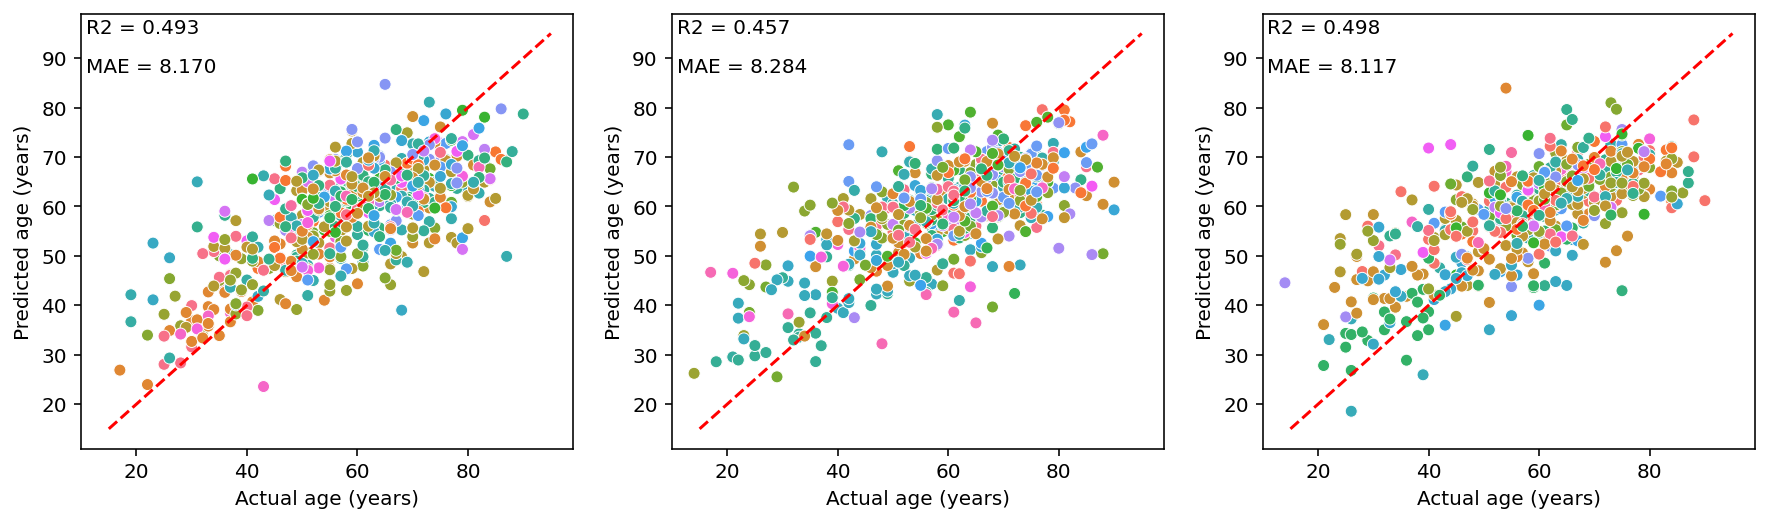

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True)
for i in range(3):
    to_plot = results_df.loc[i, 'tests'].to_frame().join(mut_clock.all_methyl_age_df_t.loc[:, 'dataset'])
    to_plot['preds'] = results_df.loc[i, 'preds']
    to_plot.columns = ['Actual age (years)', 'Dataset', 'Predicted age']
    sns.scatterplot(data=to_plot, x='Actual age (years)', y='Predicted age', hue='Dataset', ax=axes[i], legend=False)
    # axes[i].scatter(results_df.loc[i, 'tests'], results_df.loc[i, 'preds'], s=4, c=)
    # plot the identity line
    axes[i].plot([15, 95], [15, 95], color='red', linestyle='--')
    axes[i].set_xlabel('Actual age (years)')
    axes[i].set_ylabel('Predicted age (years)')
    # write r2 and mae in upper left corner
    axes[i].text(.01, .99, f"R2 = {results_df.loc[i, 'r2']:.3f}", ha='left', va='top',  transform=axes[i].transAxes )
    axes[i].text(.01, .9, f"MAE = {results_df.loc[i, 'mae']:.3f}", ha='left', va='top',  transform=axes[i].transAxes)

In [38]:
pred_results_df = mut_clock.train_epi_clock(
    X = all_pred_methyl_df,
    y = ages, 
    out_fn = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_010423",
    cpg_ids = all_pred_methyl_df.columns
    )

[Parallel(n_jobs=48)]: Using backend ThreadingBackend with 48 concurrent workers.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=48)]: Done   5 out of   5 | elapsed: 17.9min finished
[Parallel(n_jobs=48)]: Using backend ThreadingBackend with 48 concurrent workers.
.........................................................................................................................................................................................................................................................................

In [44]:
pred_results_df

,r2,mae,preds,tests
0,0.259475,10.090537,"[49.268368320565685, 72.91301899637352, 63.058...",sample TCGA-C5-A907 47 TCGA-N5-A4RJ 61 T...
1,0.253878,9.846506,"[60.14921013790499, 48.97917881323774, 66.2704...",sample TCGA-CQ-A4CH 58 TCGA-AB-2964 58 T...
2,0.260574,10.063094,"[60.44416003653516, 59.28006094391417, 60.9338...",sample TCGA-DX-A3U6 63 TCGA-OL-A5RU 63 T...


In [47]:
pred_results_df.to_csv("/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_010423/testing_predicted_methyl_top170000mi_clock_results.csv")

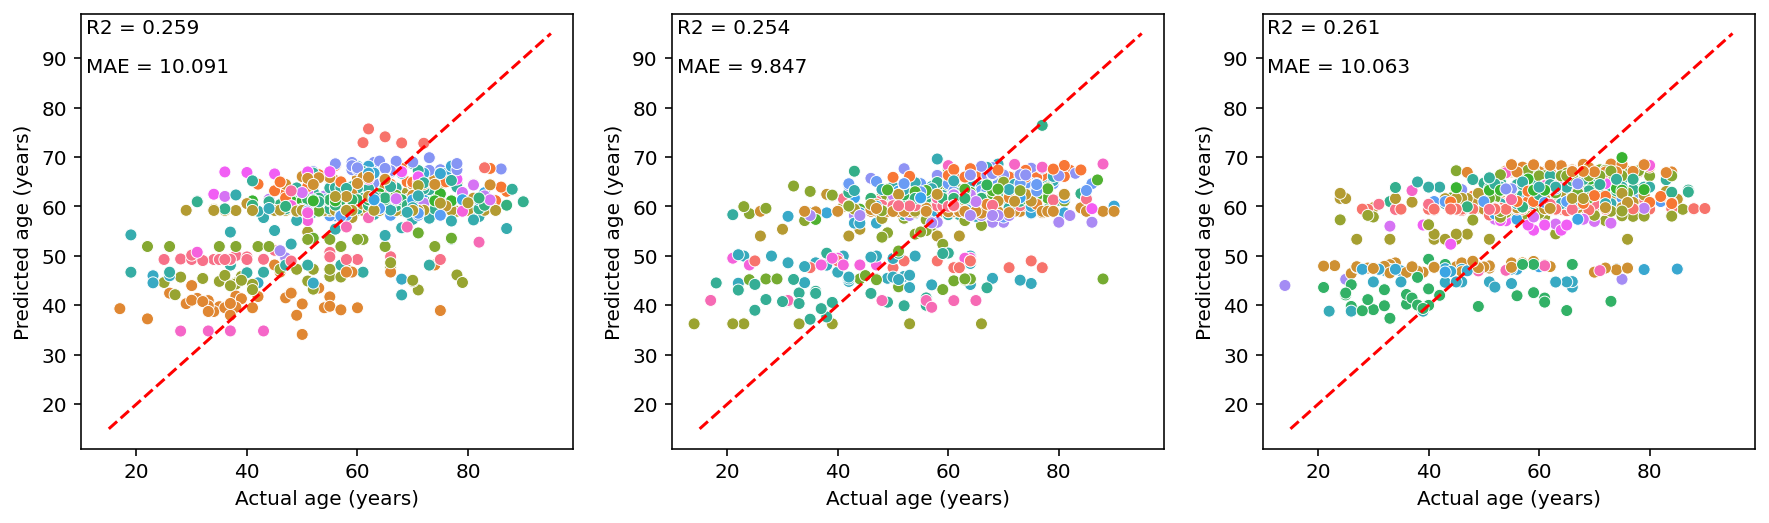

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True)
for i in range(3):
    to_plot = pred_results_df.loc[i, 'tests'].to_frame().join(mut_clock.all_methyl_age_df_t.loc[:, 'dataset'])
    to_plot['preds'] = pred_results_df.loc[i, 'preds']
    to_plot.columns = ['Actual age (years)', 'Dataset', 'Predicted age']
    sns.scatterplot(data=to_plot, x='Actual age (years)', y='Predicted age', hue='Dataset', ax=axes[i], legend=False)    # plot the identity line
    axes[i].plot([15, 95], [15, 95], color='red', linestyle='--')
    axes[i].set_xlabel('Actual age (years)')
    axes[i].set_ylabel('Predicted age (years)')
    # write r2 and mae in upper left corner
    axes[i].text(.01, .99, f"R2 = {pred_results_df.loc[i, 'r2']:.3f}", ha='left', va='top',  transform=axes[i].transAxes )
    axes[i].text(.01, .9, f"MAE = {pred_results_df.loc[i, 'mae']:.3f}", ha='left', va='top',  transform=axes[i].transAxes)
    